# Dataset Overview

## Overview of the `dacapo_toolbox.iterable_dataset` helper function

The `iterable_dataset` function is a powerful helper function that wraps around
`gunpowder` and `funlib` libraries to provide a simple and powerful entrypoint
for creating torch datasets. It's main features are:
1. Properly handling spatial augmentations such as mirroring, transposing,
elastic deformations, rotations and image scaling while handling any
necessary context without excess padding or data reads. (This is a gunpowder feature)
See the [gunpowder docs](https://funkelab.github.io/gunpowder/) for more details.
2. Robust sampling of input data using a variety of sampling strategies such as
sampling from a set of points, guaranteeing a certain amount of masked in data,
or sampling uniformly from the input data. (This is also achieved using gunpowder)
3. Creates a simple torch dataset interface that can be used with any pytorch
parallelization scheme such as `torch.utils.data.DataLoader`.
4. Can handle both arrays and graphs as input and output data.
5. Can handle arbitrary number of dimensions, easily generalizing to 3D plus time.

In [1]:
# ## A simple dataset

from dacapo_toolbox.dataset import iterable_dataset
from funlib.persistence import Array
from skimage.data import astronaut
import matplotlib.pyplot as plt

from pathlib import Path

out_ds = Path("_static/dataset_overview")
if not out_ds.exists():
    out_ds.mkdir(parents=True)

/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

dataset = iterable_dataset(
    {"astronaut": Array(astronaut().transpose((2, 0, 1)), voxel_size=(1, 1))},
    shapes={"astronaut": (256, 256)},
)
batch_gen = iter(dataset)

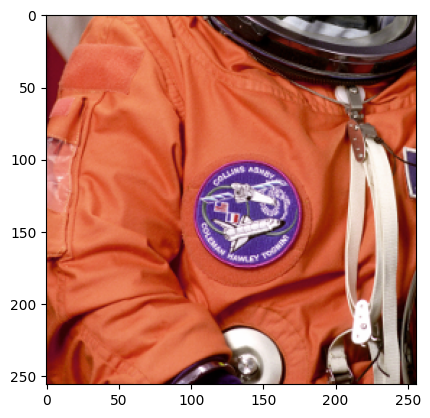

In [3]:
sample = next(batch_gen)

plt.imshow(sample["astronaut"].numpy().transpose((1, 2, 0)))
plt.show()

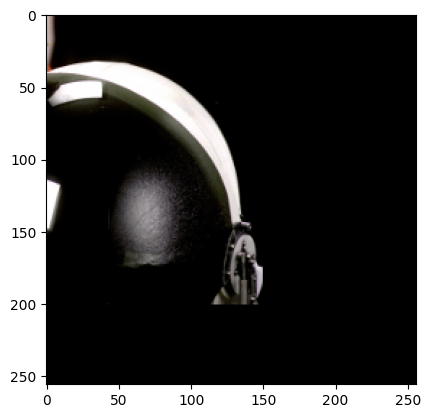

In [4]:
sample = next(batch_gen)

plt.imshow(sample["astronaut"].numpy().transpose((1, 2, 0)))
plt.show()

You may notice a couple things about the above images.

First why are we transposing and adding a voxel size? `Gunpowder` expects channel dimensions
to come before spatial dimensions, and the voxel size defines the number of spatial channels.
Allowing for a voxel size lets us handle arrays of different resolutions and makes sure we can
handle any non-isotropic data gracefully.

Second we see some padding at the side. This is because we treat every array given to us
as an infinite array padded with zeros, and by default only guarantee that the center pixel is
sampled from within the provided array. You can adjust this with the `trim` term.

In [5]:

dataset = iterable_dataset(
    {"astronaut": Array(astronaut().transpose((2, 0, 1)), voxel_size=(1, 1))},
    shapes={"astronaut": (256, 256)},
    trim=(128, 128),
)
batch_gen = iter(dataset)

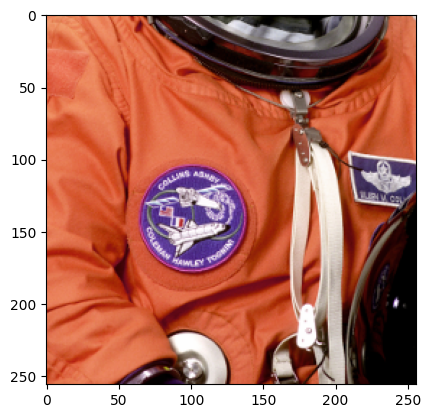

In [6]:
sample = next(batch_gen)

plt.imshow(sample["astronaut"].numpy().transpose((1, 2, 0)))
plt.show()

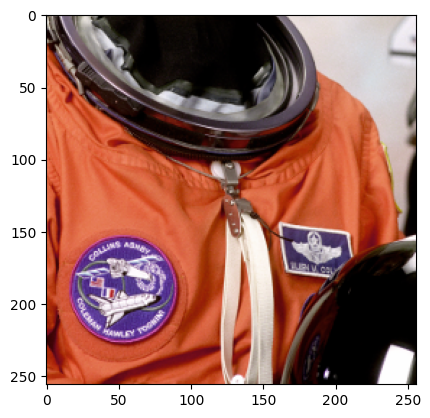

In [7]:
sample = next(batch_gen)

plt.imshow(sample["astronaut"].numpy().transpose((1, 2, 0)))
plt.show()

Now since we trim, we make sure we only choose samples where the
center pixel is at least `trim` pixels away from the edge of the image.
This guarantees that we don't get samples with padding, but this may lead
to errors if your training data is smaller than `2*trim`

Next lets add more arrays. Maybe you have multiple datasets, and multiple
arrays per dataset.

In [8]:
from skimage.data import coffee

astronaut_data = astronaut().transpose((2, 0, 1)) / 255
coffee_data = coffee().transpose((2, 0, 1)) / 255

dataset = iterable_dataset(
    {
        "image": [
            Array(astronaut_data, voxel_size=(1, 1)),
            Array(coffee_data, voxel_size=(1, 1)),
        ],
        "mask": [
            Array(
                astronaut_data[0] > (astronaut_data[1] + astronaut_data[2])
            ),  # mask in red regions
            Array(
                coffee_data[0] > (coffee_data[1] + coffee_data[2])
            ),  # mask in red regions
        ],
    },
    shapes={"image": (256, 256), "mask": (256, 256)},
)
batch_gen = iter(dataset)

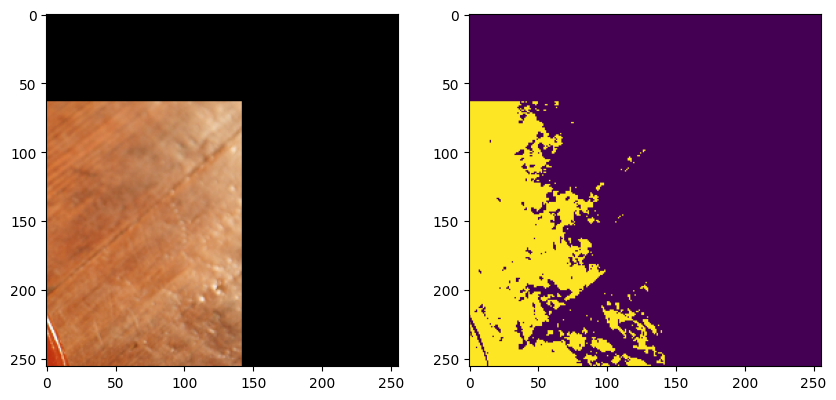

In [9]:
sample = next(batch_gen)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample["image"].numpy().transpose((1, 2, 0)))
ax[1].imshow(sample["mask"].numpy())
plt.show()

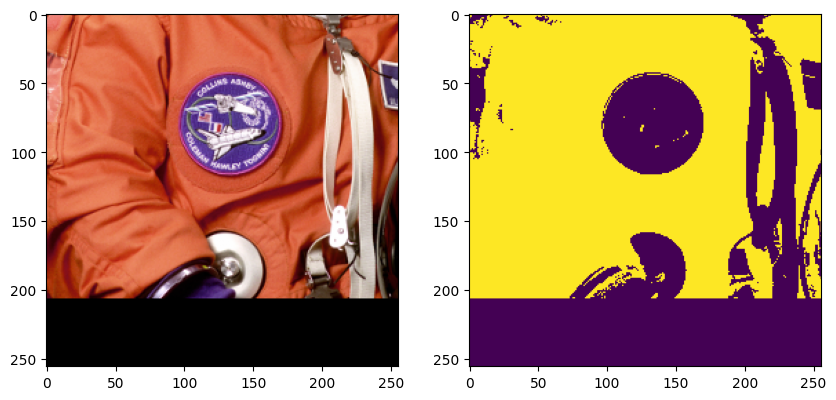

In [10]:
sample = next(batch_gen)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample["image"].numpy().transpose((1, 2, 0)))
ax[1].imshow(sample["mask"].numpy())
plt.show()

Lets add a graph to the dataset. We use the `networkx` library
to interface with graphs. Each node in the graph must have a `position`
attribute in *world coordinates*, this means accounting for the
voxel size of the arrays given. In our case voxel size is (1, 1) so
we can just use the pixel coordinates. We'll use a simple grid of points as our graph.

In [11]:
import networkx as nx
from itertools import product


def gen_graphs():
    graphs = []
    for img_data in [astronaut_data, coffee_data]:
        graph = nx.Graph()
        for i, j in product(
            range(0, img_data.shape[1], 32), range(0, img_data.shape[2], 32)
        ):
            graph.add_node(i * img_data.shape[2] + j, position=(i + 0.5, j + 0.5))
        graphs.append(graph)
    return graphs

In [12]:
# Lets request the graph in a smaller region. It will be centered within the data
# we ask for.

In [13]:

dataset = iterable_dataset(
    {
        "image": [
            Array(astronaut_data, voxel_size=(1, 1)),
            Array(coffee_data, voxel_size=(1, 1)),
        ],
        "mask": [
            Array(
                astronaut_data[0] > (astronaut_data[1] + astronaut_data[2])
            ),  # mask in red regions
            Array(
                coffee_data[0] > (coffee_data[1] + coffee_data[2])
            ),  # mask in red regions
        ],
        "graph": gen_graphs(),
    },
    shapes={"image": (256, 256), "mask": (256, 256), "graph": (128, 128)},
)
batch_gen = iter(dataset)

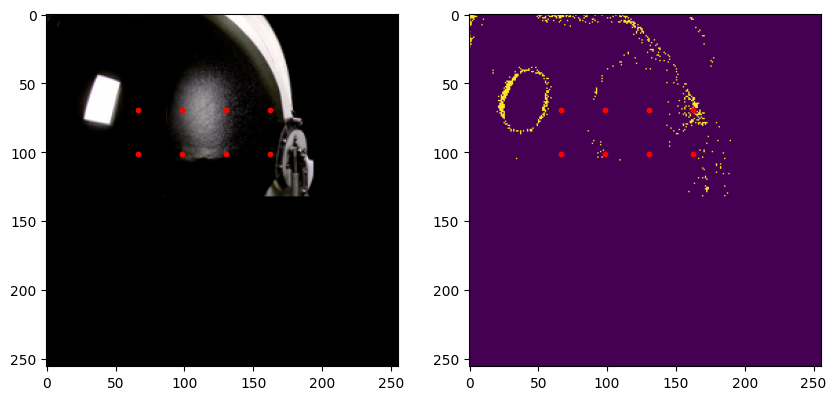

In [14]:
import numpy as np

sample = next(batch_gen)

graph = sample["graph"]
xs = np.array([attrs["position"][0] for attrs in graph.nodes.values()])
ys = np.array([attrs["position"][1] for attrs in graph.nodes.values()])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample["image"].numpy().transpose((1, 2, 0)))
ax[0].scatter(ys, xs, c="red", s=10)
ax[1].imshow(sample["mask"].numpy())
ax[1].scatter(ys, xs, c="red", s=10)
plt.show()

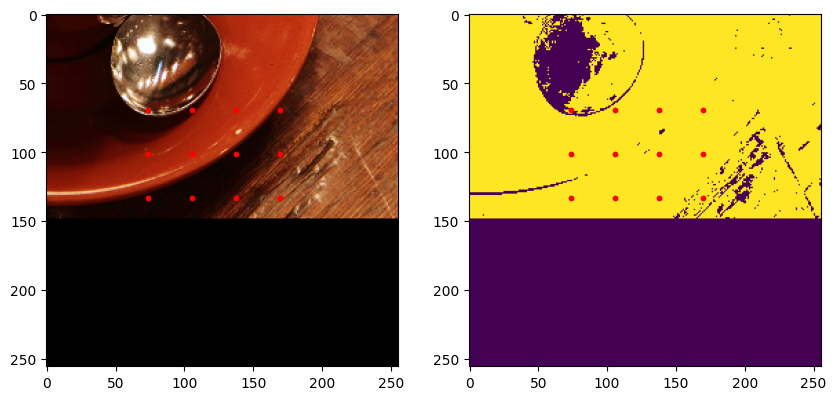

In [15]:
sample = next(batch_gen)

graph = sample["graph"]
xs = np.array([attrs["position"][0] for attrs in graph.nodes.values()])
ys = np.array([attrs["position"][1] for attrs in graph.nodes.values()])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample["image"].numpy().transpose((1, 2, 0)))
ax[0].scatter(ys, xs, c="red", s=10)
ax[1].imshow(sample["mask"].numpy())
ax[1].scatter(ys, xs, c="red", s=10)
plt.show()

## Augmentations/Transformations

We almost always want to transform our data in some way. The `iterable_dataset`
differentiates between two types of transformations:
1. **Spatial augmentations**: These are augmentations that change the spatial
   properties of the data. For example, mirroring, transposing, elastic deformations.
2. **Non-spatial augmentations**: These are augmentations that operate on the image
   content itself. For example, adding noise, changing brightness, binarizing, etc.

### Spatial augmentations

We take two config classes that parameterize the spatial augmentations we support.
`DeformAugmentConfig`, and `SimpleAugmentConfig`.
1. The `DeformAugmentConfig` handles continuous transforms requiring interpolation.
This includes rotation, scaling and elastically deforming.
2. The `SimpleAugmentConfig` handles discrete transforms that don't require interpolation.
This includes mirroring and transposing.

In [16]:
from dacapo_toolbox.dataset import DeformAugmentConfig, SimpleAugmentConfig


dataset = iterable_dataset(
    {
        "image": [
            Array(astronaut_data, voxel_size=(1, 1)),
            Array(coffee_data, voxel_size=(1, 1)),
        ],
        "graph": gen_graphs(),
    },
    shapes={"image": (256, 256), "graph": (128, 128)},
    simple_augment_config=SimpleAugmentConfig(p=1.0, mirror_only=[1]),
    deform_augment_config=DeformAugmentConfig(
        p=1.0,
        control_point_spacing=(8, 8),
        jitter_sigma=(8.0, 8.0),
        scale_interval=(0.5, 2.0),
        rotate=True,
    ),
)
batch_gen = iter(dataset)

/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:1550: RuntimeWarning: invalid value encountered in divide
  results = [sum_labels(input * grids[dir].astype(float), labels, index) / normalizer


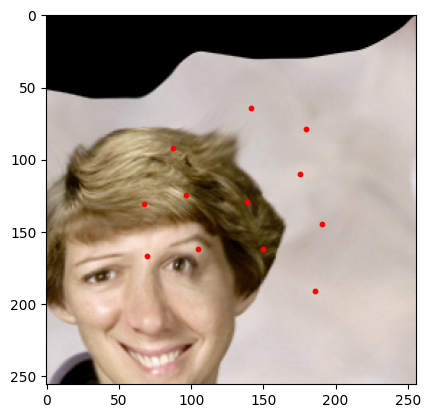

In [17]:
sample = next(batch_gen)

graph = sample["graph"]
xs = np.array([attrs["position"][0] for attrs in graph.nodes.values()])
ys = np.array([attrs["position"][1] for attrs in graph.nodes.values()])

plt.imshow(sample["image"].numpy().transpose((1, 2, 0)))
plt.scatter(ys, xs, c="red", s=10)
plt.show()

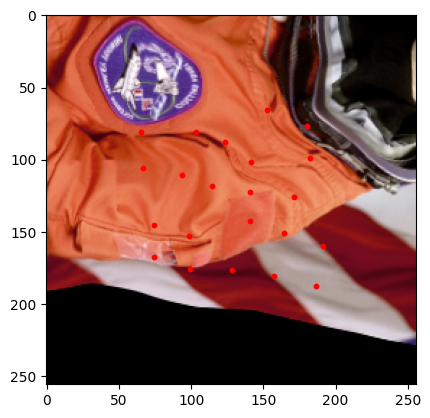

In [18]:
sample = next(batch_gen)

graph = sample["graph"]
xs = np.array([attrs["position"][0] for attrs in graph.nodes.values()])
ys = np.array([attrs["position"][1] for attrs in graph.nodes.values()])

plt.imshow(sample["image"].numpy().transpose((1, 2, 0)))
plt.scatter(ys, xs, c="red", s=10)
plt.show()

### Non-spatial augmentations

Non-spatial augmentations are handled using the `transforms` argument to the
`iterable_dataset` function. This is a dictionary of tuples, where the key is
a tuple of input and output keys, and the value is a callable that takes the
designated inputs, and generates the designated outputs.

e.g. `(("a", "b"), ("c", "d")): transform_1` means we expect `transform_1` to take
2 tensors in ("a", "b"), and produce 2 tensors ("c", "d").

`("a", "c"): transform_2` is short hand for a transform that takes a single tensor
in and outputs a single tensor.

`"a": transform_3` is short hand for a transform that takes in a single tensor and
produces a single tensor that should replace the input tensor.

Lets see some examples:

In [19]:
from torchvision.transforms import v2 as transforms

dataset = iterable_dataset(
    {
        "image": [
            Array(astronaut_data, voxel_size=(1, 1)),
            Array(coffee_data, voxel_size=(1, 1)),
        ],
    },
    transforms={
        "image": transforms.GaussianBlur(3, sigma=(2.0, 2.0)),
        ("image", "mask"): lambda d: d[0] > d[1] + d[2],  # mask in red regions
        (("mask", "image"), "masked_image"): lambda mask, image: mask * image,
    },
    shapes={"image": (256, 256)},
)
batch_gen = iter(dataset)

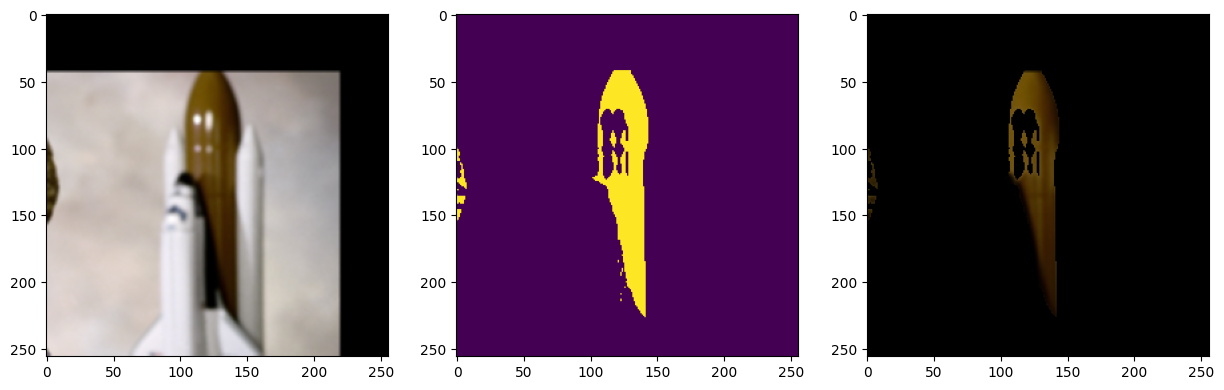

In [20]:
sample = next(batch_gen)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample["image"].numpy().transpose((1, 2, 0)))
ax[1].imshow(sample["mask"].numpy())
ax[2].imshow(sample["masked_image"].numpy().transpose((1, 2, 0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000000000002].


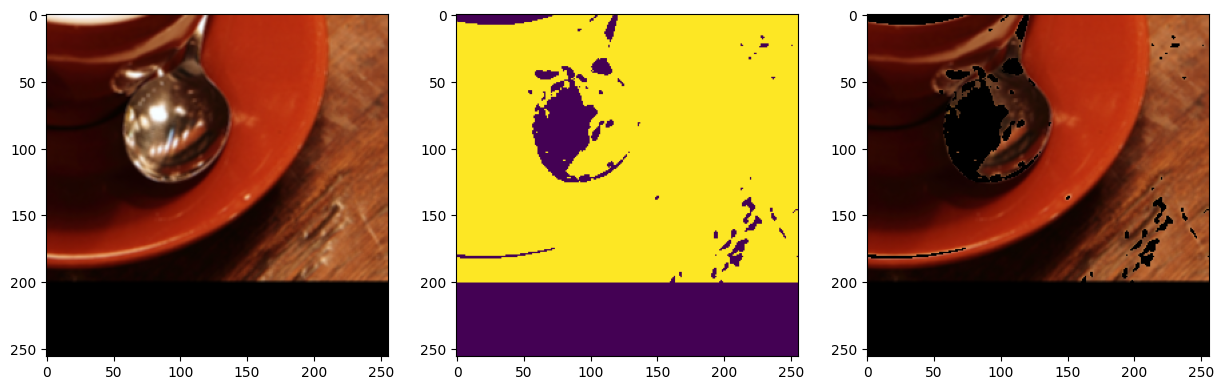

In [21]:
sample = next(batch_gen)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample["image"].numpy().transpose((1, 2, 0)))
ax[1].imshow(sample["mask"].numpy())
ax[2].imshow(sample["masked_image"].numpy().transpose((1, 2, 0)))
plt.show()

The iterable dataset is very flexible and can handle a variety of use cases.
Below is a more complex example showing a dataset with multiple datasets at various
resolutions, using different sampling strategies, spatial and non-spatial augmentations,
and both arrays and graphs as input and output.

We generate 2 synthetic datasets with different sized blobs. `blobs_a` and `blobs_b`.
We create raw and ground truth arrays in scale pyramid fashion for each dataset.
`blobs_a` two scale levels s0 and s1 with voxel sizes (raw: (1, 1), gt: (2, 2)) and (raw: (2, 2), gt: (4, 4)) respectively.
`blobs_b` two scale levels s0 and s1 with voxel sizes (raw: (1, 1), gt: (2, 2)) and (raw: (2, 2), gt: (4, 4)) respectively.
We also create a mask for each dataset that masks out half the image. The iterable dataset function
has no problem generating samples from a variety of different voxel sizes, different sampling strategies, etc.

Batch 0


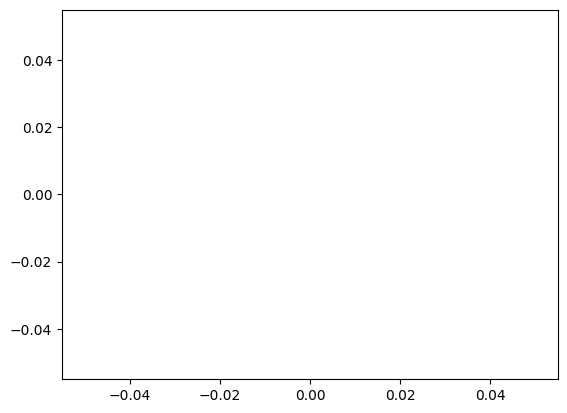

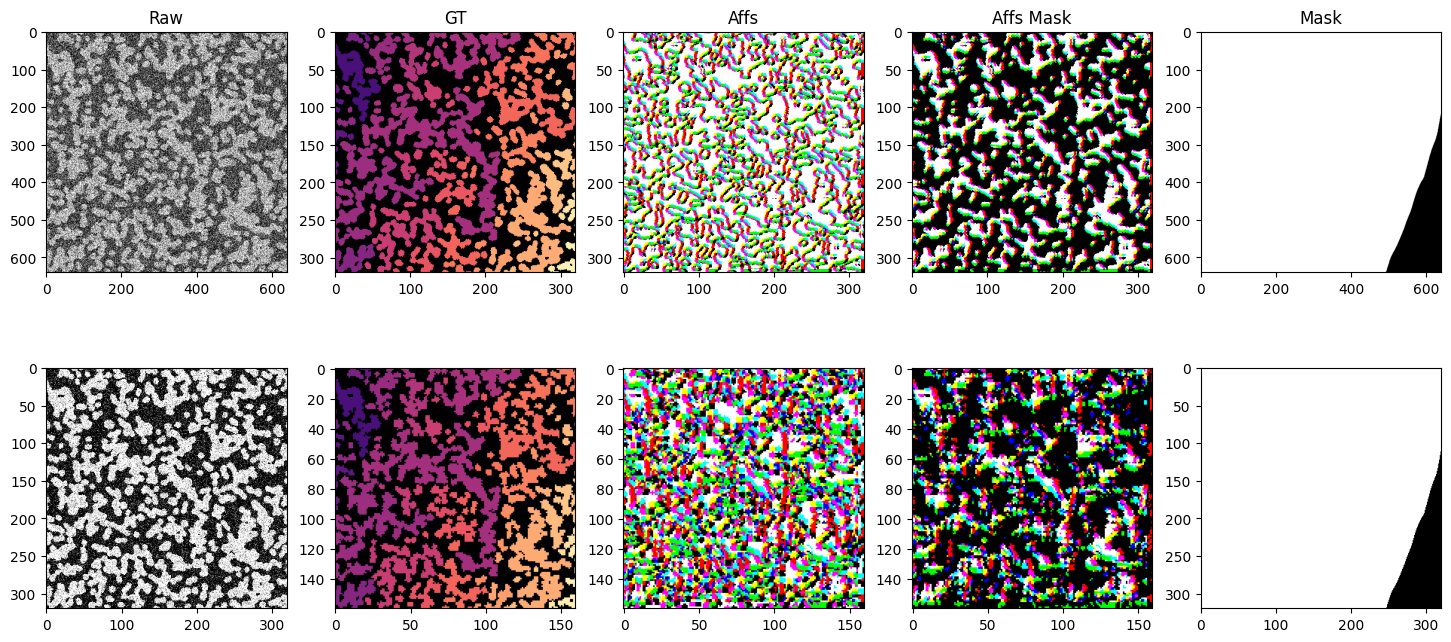

Batch 1


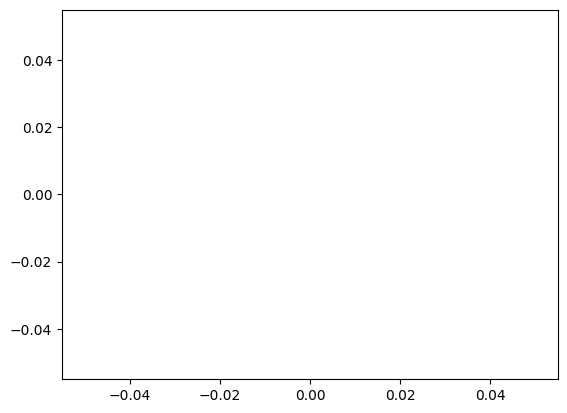

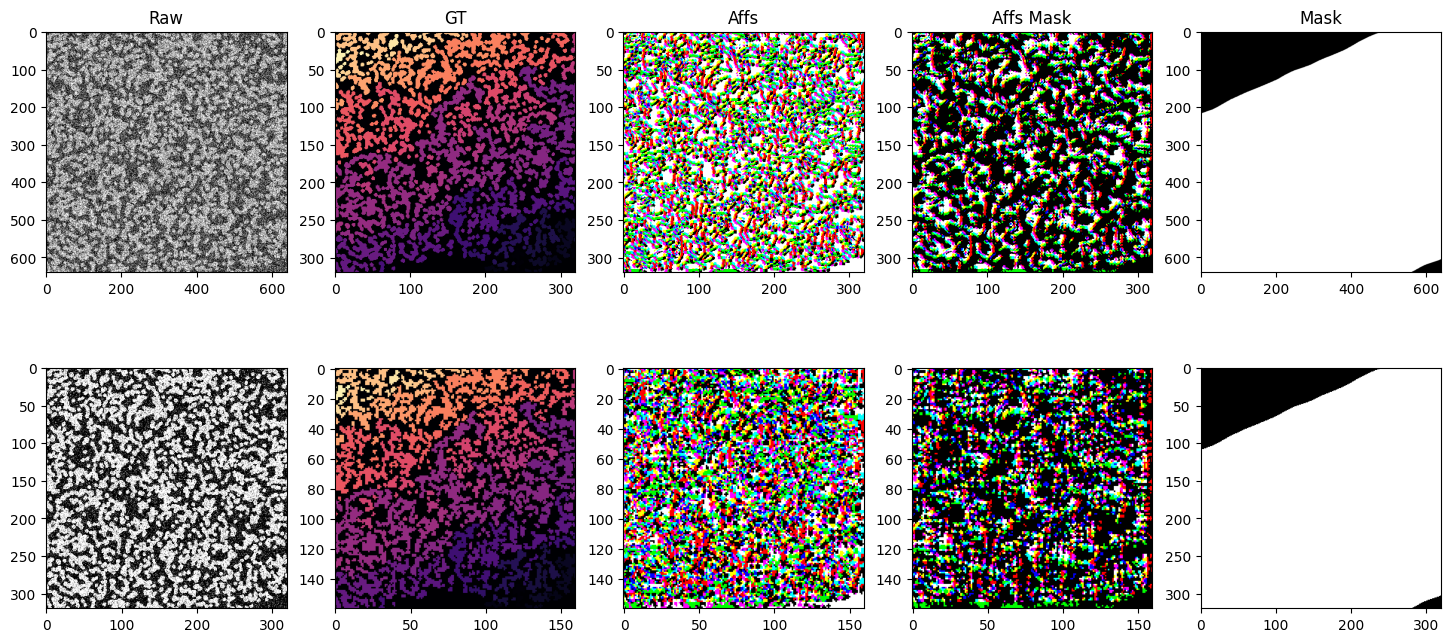

Batch 2


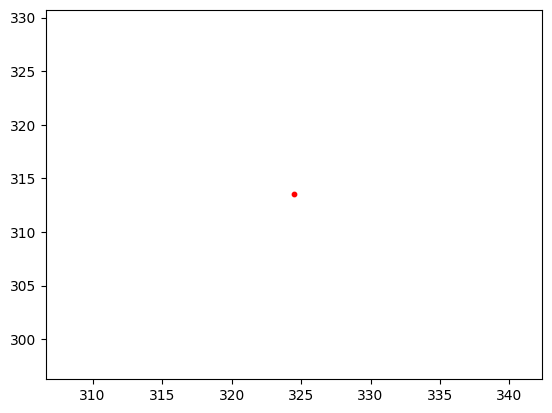

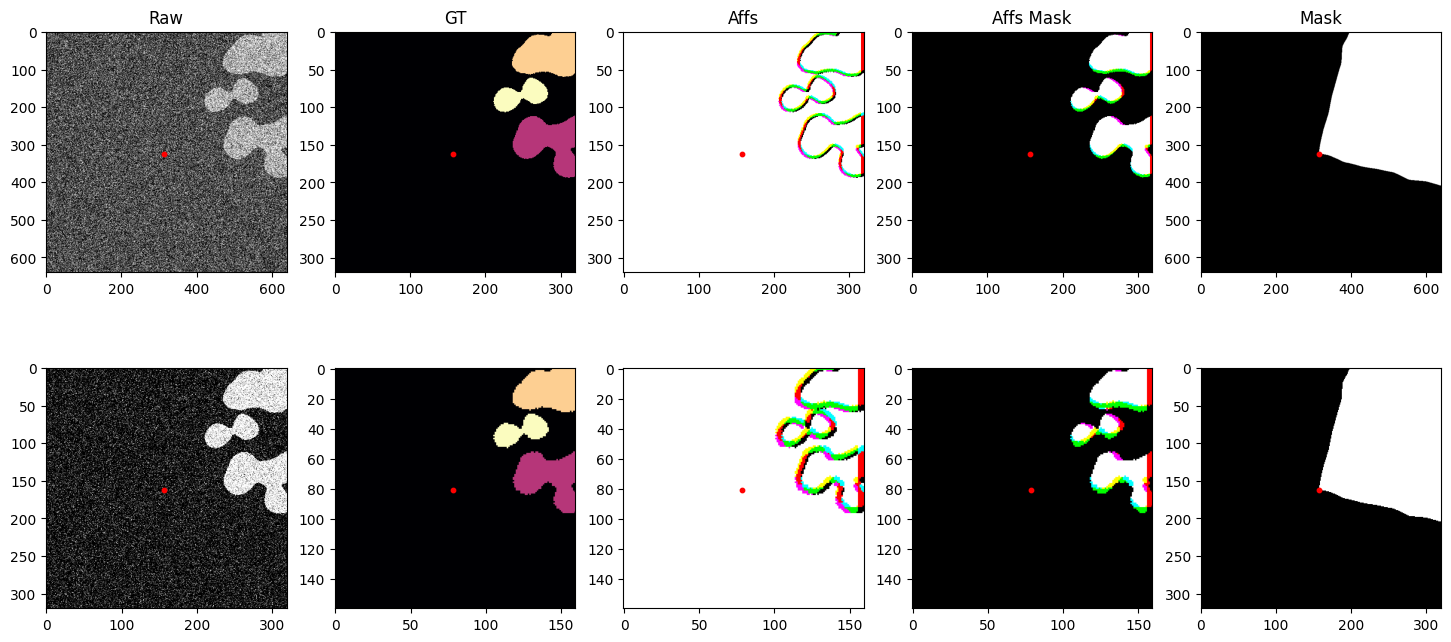

Batch 3


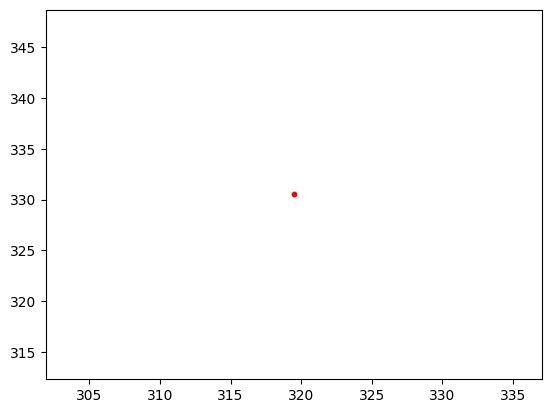

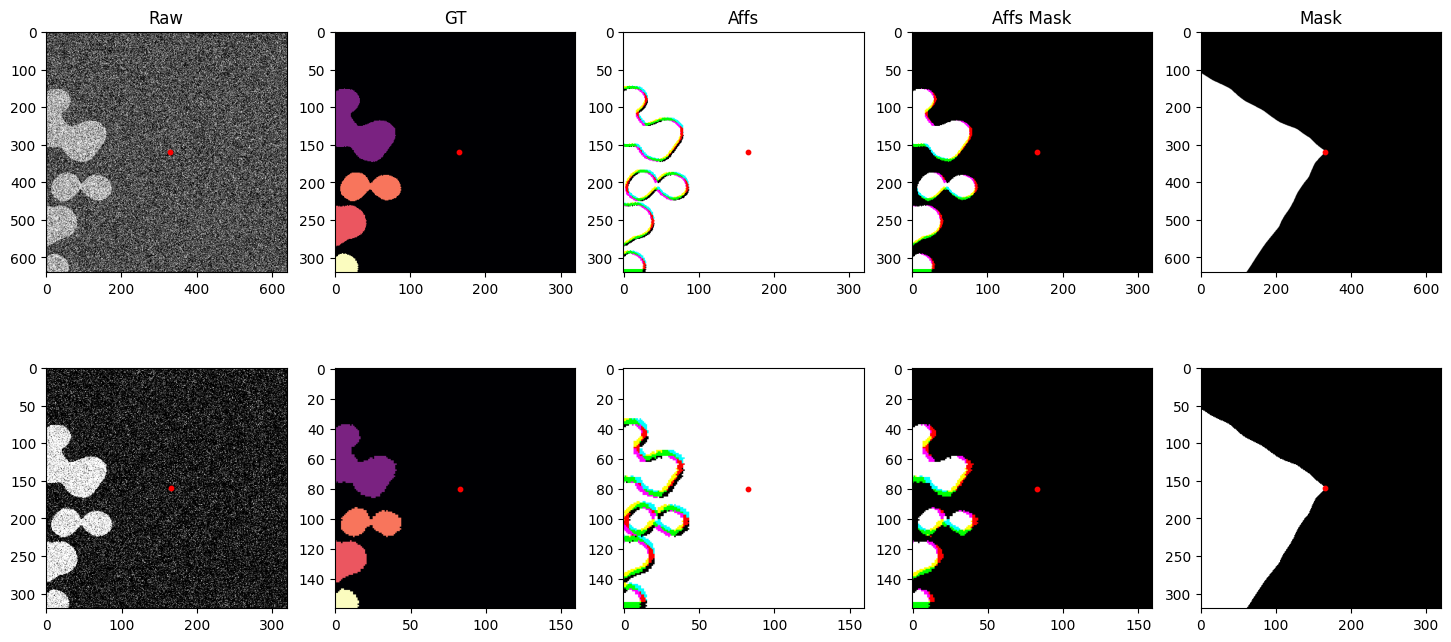

Batch 4


In [22]:
from dacapo_toolbox.dataset import (
    iterable_dataset,
    SimpleAugmentConfig,
    DeformAugmentConfig,
    MaskedSampling,
    PointSampling,
)
from dacapo_toolbox.transforms.affs import Affs, AffsMask
from funlib.persistence import Array
from skimage import data
from torchvision.transforms import v2 as transforms
import numpy as np
from skimage.measure import label

side_length = 2048

# two different datasets with vastly different blob sizes
blobs_a = data.binary_blobs(
    length=side_length, blob_size_fraction=20 / side_length, n_dim=2
)
blobs_a_gt = label(blobs_a, connectivity=2)
blobs_b = data.binary_blobs(
    length=side_length, blob_size_fraction=100 / side_length, n_dim=2
)
blobs_b_gt = label(blobs_b, connectivity=2)
mask = np.ones((side_length, side_length), dtype=bool)
mask[side_length // 2 : side_length] = 0

# raw and gt arrays at various voxel sizes
raw_a_s0 = Array(blobs_a[::1, ::1], offset=(0, 0), voxel_size=(1, 1))
raw_a_s1 = Array(blobs_a[::2, ::2], offset=(0, 0), voxel_size=(2, 2))
raw_b_s0 = Array(blobs_b[::1, ::1], offset=(0, 0), voxel_size=(2, 2))
raw_b_s1 = Array(blobs_b[::2, ::2], offset=(0, 0), voxel_size=(4, 4))
gt_a_s0 = Array(blobs_a_gt[::2, ::2], offset=(0, 0), voxel_size=(2, 2))
gt_a_s1 = Array(blobs_a_gt[::4, ::4], offset=(0, 0), voxel_size=(4, 4))
gt_b_s0 = Array(blobs_b_gt[::2, ::2], offset=(0, 0), voxel_size=(4, 4))
gt_b_s1 = Array(blobs_b_gt[::4, ::4], offset=(0, 0), voxel_size=(8, 8))
mask_a = Array(mask, offset=(0, 0), voxel_size=(1, 1))
mask_b = Array(mask, offset=(0, 0), voxel_size=(2, 2))

g = nx.Graph()
g.add_nodes_from(
    [
        (i, {"position": position})
        for i, position in enumerate(
            [
                (side_length * 2 - 0.5, side_length * 2 - 0.5),
                (0.5, side_length * 2 - 0.5),
                (side_length * 2 - 0.5, 0.5),
                (0.5, 0.5),
            ]
        )
    ]
)

# defining the datasets
iter_ds = iterable_dataset(
    {
        "raw_s0": [raw_a_s0, raw_b_s0],
        "gt_s0": [gt_a_s0, gt_b_s0],
        "raw_s1": [raw_a_s1, raw_b_s1],
        "gt_s1": [gt_a_s1, gt_b_s1],
        "mask": [mask_a, mask_b],
        "mask_dummy": [mask_a, mask_b],
        "sample_points": [None, g],
    },
    shapes={
        "raw_s0": (128 * 5, 128 * 5),
        "gt_s0": (64 * 5, 64 * 5),
        "raw_s1": (64 * 5, 64 * 5),
        "gt_s1": (32 * 5, 32 * 5),
        "mask": (128 * 5, 128 * 5),
        "mask_dummy": (64 * 5, 64 * 5),
        "sample_points": (128 * 5, 128 * 5),
    },
    sampling_strategies=[
        MaskedSampling("mask_dummy", 0.8),
        PointSampling("sample_points"),
    ],
    transforms={
        ("raw_s0", "noisy_s0"): transforms.Compose(
            [transforms.ConvertImageDtype(), transforms.GaussianNoise(sigma=1.0)]
        ),
        ("raw_s1", "noisy_s1"): transforms.Compose(
            [transforms.ConvertImageDtype(), transforms.GaussianNoise(sigma=0.3)]
        ),
        ("gt_s0", "affs_s0"): Affs([[4, 0], [0, 4], [4, 4]]),
        ("gt_s0", "affs_mask_s0"): AffsMask([[4, 0], [0, 4], [4, 4]]),
        ("gt_s1", "affs_s1"): Affs([[4, 0], [0, 4], [4, 4]]),
        ("gt_s1", "affs_mask_s1"): AffsMask([[4, 0], [0, 4], [4, 4]]),
    },
    simple_augment_config=SimpleAugmentConfig(
        p=1.0, mirror_probs=[1.0, 0.0], transpose_only=[]
    ),
    deform_augment_config=DeformAugmentConfig(
        p=1.0,
        control_point_spacing=(10, 10),
        jitter_sigma=(5.0, 5.0),
        scale_interval=(0.5, 2.0),
        rotate=True,
    ),
)

import matplotlib.pyplot as plt

for i, batch in enumerate(iter_ds):
    print(f"Batch {i}")
    if i >= 4:  # Limit to 4 batches for demonstration
        break
    points = batch["sample_points"]
    xs = np.array([attrs["position"][0] for attrs in points.nodes.values()])
    ys = np.array([attrs["position"][1] for attrs in points.nodes.values()])
    plt.scatter(xs, ys, c="red", s=10)

    fig, axs = plt.subplots(2, 5, figsize=(18, 8))
    axs[0, 0].imshow(batch["noisy_s0"], cmap="gray")
    axs[0, 1].imshow(batch["gt_s0"], cmap="magma")
    axs[0, 2].imshow(batch["affs_s0"].permute(1, 2, 0).float())
    axs[0, 3].imshow(batch["affs_mask_s0"].permute(1, 2, 0).float())
    axs[0, 4].imshow(batch["mask"].float(), vmin=0, vmax=1, cmap="gray")
    axs[1, 0].imshow(batch["noisy_s1"], cmap="gray")
    axs[1, 1].imshow(batch["gt_s1"], cmap="magma")
    axs[1, 2].imshow(batch["affs_s1"].permute(1, 2, 0).float())
    axs[1, 3].imshow(batch["affs_mask_s1"].permute(1, 2, 0).float())
    axs[1, 4].imshow(batch["mask"][::2, ::2].float(), vmin=0, vmax=1, cmap="gray")
    for a, b in product(range(2), range(5)):
        s = 2 ** (a + (b % 4 != 0))
        axs[a, b].scatter(ys / s, xs / s, c="red", s=10)

    axs[0, 0].set_title("Raw")
    axs[0, 1].set_title("GT")
    axs[0, 2].set_title("Affs")
    axs[0, 3].set_title("Affs Mask")
    axs[0, 4].set_title("Mask")

    plt.show()